## Here we will try to use convolution model: $\sum_t r_{t - 1, t}^2 * w_t$, where w_i will be fit, r - returns

In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from utils import rmspe

In [190]:
train_targets = pd.read_csv('train.csv')

In [191]:
import os
import re
stock_ids = sorted(
    [int(re.sub('stock_id=', '', x)) for x in os.listdir('book_train.parquet')])

In [237]:
stock_id = stock_ids[0]

In [238]:
book = pd.read_parquet('book_train.parquet/stock_id=' + str(stock_id))
trades = pd.read_parquet('trade_train.parquet/stock_id=' + str(stock_id))

In [239]:
book['wap'] = (book['bid_price1'] * book['ask_size1'] + book['ask_price1'] * book['bid_size1']) / (
    book['ask_size1'] + book['bid_size1'])
    
book['log_price'] = np.log(book['wap'])
book['bucket_in_bucket'] = book['seconds_in_bucket'] // 100
book['log_return'] = book.groupby(['time_id', 'bucket_in_bucket'])['log_price'].diff()
book = book[~book['log_return'].isnull()]
book['stock_id'] = stock_id

In [240]:
book['seconds_to_end'] = 600 - book['seconds_in_bucket']
book = pd.merge(book, train_targets, how='left', on=['time_id', 'stock_id'])

In [241]:
time_ids = np.random.permutation(book['time_id'].unique())
train_ids = time_ids[:2500]
test_ids = time_ids[2500:]

In [242]:
train = book[book.time_id.apply(lambda x: x in train_ids)]
test = book[book.time_id.apply(lambda x: x in test_ids)]

In [243]:
valid_cols = ['time_id', 'log_return', 'seconds_to_end', 'stock_id', 'target']
train = train[valid_cols]
test = test[valid_cols]

In [244]:
lr = 100
weights = np.ones(600)
n_steps = 200
lambda_ = 0

In [245]:
loss_history = []

In [247]:
from IPython.core.display import clear_output

def train_weights(train, weights, n_steps=120, verbose=True):
    for n in trange(n_steps):
        weights_df = pd.DataFrame({'weights': weights, 'seconds_to_end': range(600)})
        train_merged = pd.merge(train, weights_df, how='left', on='seconds_to_end')
        train_merged['weighted_log_return'] = train_merged['log_return'] ** 2 * train_merged['weights']
        train_merged['answer'] = train_merged.groupby('time_id')['weighted_log_return'].transform(
            lambda x: x.sum() ** 0.5)

        train_merged['der'] = (train_merged['answer'] - train_merged['target']
                          ) / train_merged['target'] * train_merged['log_return']**2

        weights = weights_df['weights']
        reg = -(weights.diff() * (weights.diff() > 0)).fillna(0) + (
            -weights.diff(-1) * (weights.diff(-1) < 0)).fillna(0)


        delta_w = train_merged.groupby('seconds_to_end')['der'].sum().reset_index()
        temp = pd.merge(weights_df, delta_w, on=['seconds_to_end'], how='outer').fillna(0)
        weights = temp['weights'] - lr * temp['der'] - reg * lambda_
        weights = weights.clip(lower=0)
        train_merged['err'] = ((train_merged['target'] - train_merged['answer']) / train_merged['target']) ** 2
        loss = train_merged.groupby('time_id')['err'].last().mean() ** 0.5
        loss_history.append(loss)

        if n % 10 == 0:
            if not verbose:
                continue
            clear_output()
            plt.plot(loss_history)
            plt.show()
    return weights

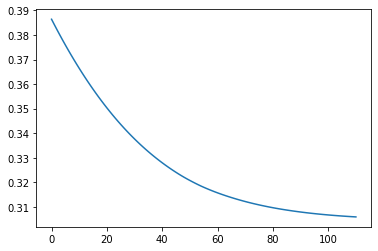





 92%|█████████▎| 111/120 [02:45<00:12,  1.40s/it]



 93%|█████████▎| 112/120 [02:46<00:11,  1.44s/it]



 94%|█████████▍| 113/120 [02:47<00:09,  1.41s/it]



 95%|█████████▌| 114/120 [02:49<00:08,  1.37s/it]



 96%|█████████▌| 115/120 [02:50<00:06,  1.40s/it]



 97%|█████████▋| 116/120 [02:51<00:05,  1.33s/it]



 98%|█████████▊| 117/120 [02:52<00:03,  1.27s/it]



 98%|█████████▊| 118/120 [02:54<00:02,  1.27s/it]



 99%|█████████▉| 119/120 [02:55<00:01,  1.24s/it]



100%|██████████| 120/120 [02:56<00:00,  1.47s/it]


In [248]:
weights = train_weights(train, weights)

In [231]:
valid_cols = ['time_id', 'log_return', 'seconds_to_end', 'stock_id']
to_merge = []

for stock_id in tqdm(stock_ids):
    book = pd.read_parquet('book_train.parquet/stock_id=' + str(stock_id))
    book['wap'] = (book['bid_price1'] * book['ask_size1'] + book['ask_price1'] * book['bid_size1']) / (
    book['ask_size1'] + book['bid_size1'])
    
    book['log_price'] = np.log(book['wap'])
    book['bucket_in_bucket'] = book['seconds_in_bucket'] // 100
    book['log_return'] = book.groupby(['time_id', 'bucket_in_bucket'])['log_price'].diff()
    book = book[~book['log_return'].isnull()]
    book['stock_id'] = stock_id
    
    book['seconds_to_end'] = 600 - book['seconds_in_bucket']
    
    weights_df = pd.DataFrame({'weights': weights, 'seconds_to_end': range(600)})
    
    train = book[valid_cols]
    train_merged = pd.merge(train, weights_df, how='left', on='seconds_to_end')
    train_merged['weighted_log_return'] = train_merged['log_return'] ** 2 * train_merged['weights']
    train_merged['answer'] = train_merged.groupby('time_id')['weighted_log_return'].transform(
        lambda x: x.sum() ** 0.5)
    
    temp = train_merged.groupby('time_id')[['answer', 'stock_id']].last().reset_index()
    to_merge.append(temp)





  0%|          | 0/112 [00:00<?, ?it/s]



  1%|          | 1/112 [00:06<12:55,  6.99s/it]



  2%|▏         | 2/112 [00:14<12:55,  7.05s/it]



  3%|▎         | 3/112 [00:21<12:48,  7.05s/it]



  4%|▎         | 4/112 [00:28<12:50,  7.13s/it]



  4%|▍         | 5/112 [00:35<12:51,  7.21s/it]



  5%|▌         | 6/112 [00:43<12:46,  7.23s/it]



  6%|▋         | 7/112 [00:50<12:48,  7.32s/it]



  7%|▋         | 8/112 [00:57<12:34,  7.26s/it]



  8%|▊         | 9/112 [01:04<12:21,  7.20s/it]



  9%|▉         | 10/112 [01:11<12:02,  7.08s/it]



 10%|▉         | 11/112 [01:18<11:56,  7.10s/it]



 11%|█         | 12/112 [01:25<11:41,  7.02s/it]



 12%|█▏        | 13/112 [01:32<11:34,  7.01s/it]



 12%|█▎        | 14/112 [01:39<11:28,  7.02s/it]



 13%|█▎        | 15/112 [01:47<11:31,  7.13s/it]



 14%|█▍        | 16/112 [01:53<11:15,  7.03s/it]



 15%|█▌        | 17/112 [02:01<11:19,  7.15s/it]



 16%|█▌        | 18/112 [02:07<10:55,  6.97s/it]



 17%|█▋        | 19/112 [0

In [232]:
temp = pd.concat(to_merge)

In [233]:
temp1 = pd.merge(train_targets, temp, how='inner', on=['stock_id', 'time_id'])

In [234]:
temp1['loss'] = ((temp1['target'] - temp1['answer']) / temp1['target']) ** 2

In [236]:
temp1['loss'].mean() ** 0.5

0.300376172389584

In [184]:
weights

In [86]:
temp1.groupby('stock_id')['loss'].agg(lambda x: x.mean() ** 0.5)

stock_id
0      0.305859
1      0.263728
2      0.264201
3      0.271276
4      0.308343
         ...   
122    0.265655
123    0.258144
124    0.230686
125    0.277592
126    0.283984
Name: loss, Length: 112, dtype: float64

In [110]:
temp[temp['answer'].isna()]

,time_id,answer,stock_id
113,1070,NaN,0
3290,27627,NaN,6
3444,29226,NaN,21
3581,30474,NaN,28
374,3009,NaN,31
911,7460,NaN,31
1042,8706,NaN,31
1960,16288,NaN,31
2215,18234,NaN,31
2990,25166,NaN,31


In [112]:
x = to_merge[0]

In [116]:
valid_cols = ['time_id', 'log_return', 'seconds_to_end', 'stock_id']

book = pd.read_parquet('book_train.parquet/stock_id=' + str(0))
book['wap'] = (book['bid_price1'] * book['ask_size1'] + book['ask_price1'] * book['bid_size1']) / (
book['ask_size1'] + book['bid_size1'])

book['log_price'] = np.log(book['wap'])
book['bucket_in_bucket'] = book['seconds_in_bucket'] // 100
book['log_return'] = book.groupby(['time_id', 'bucket_in_bucket'])['log_price'].diff()
book = book[~book['log_return'].isnull()]
book['stock_id'] = stock_id

book['seconds_to_end'] = 600 - book['seconds_in_bucket']

weights_df = pd.DataFrame({'weights': weights, 'seconds_to_end': range(600)})

train = book[valid_cols]
train_merged = pd.merge(train, weights_df, how='left', on='seconds_to_end')
train_merged['weighted_log_return'] = train_merged['log_return'] ** 2 * train_merged['weights']
train_merged['answer'] = train_merged.groupby('time_id')['weighted_log_return'].transform(
    lambda x: x.sum() ** 0.5)

temp = train_merged.groupby('time_id')[['answer', 'stock_id']].last().reset_index()

/home/dro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


In [136]:
train = book[valid_cols]
train_merged = pd.merge(train, weights_df, how='left', on='seconds_to_end')
train_merged['weighted_log_return'] = train_merged['log_return'] ** 2 * train_merged['weights']


In [138]:
x = train_merged[train_merged.time_id == 1070].dropna()

In [142]:
x['weighted_log_return'].sum()

-1.5737101323734858e-06